In [9]:
import tensorflow as tf
import tqdm
import numpy as np
import pandas
from RLEnvironment import *
from policy_cnn import *
from pf_vector_memory import *
from stocks_parameters import *
from data_pre_processing import *

In [10]:
def get_random_action(num_tickers):
    vector_rand = np.random.rand(num_tickers + 1)
    return vector_rand / np.sum(vector_rand)
pivot_table_stocks = pd.read_csv('stocks.csv')

In [11]:
def max_drawdown(weights, time_period=num_trading_periods, portfolio_data_frame=pivot_table_stocks):
    weights = weights.reshape(len(weights[0],))
    weights = weights[1:]
    simulated_portfolio = weights[0]*portfolio_data_frame.ix[:,0]
    for i in range(1, len(portfolio_data_frame.columns)):
        simulated_portfolio += weights[i]*portfolio_data_frame.ix[:,i]
    max_drawdown_value = float('-inf')
    for i in range(int(len(simulated_portfolio)/time_period)-1):
        if min(simulated_portfolio[i*time_period:(i+1)*time_period]) > 0:
            biggest_variation = max(simulated_portfolio[i*time_period:(i+1)*time_period])/min(simulated_portfolio[i*time_period:(i+1)*time_period])
        else:
            biggest_variation = 0
        if(biggest_variation > max_drawdown_value):
            max_drawdown_value = biggest_variation
    return max_drawdown_value

In [12]:
def RoMad(weights, mdd, returns_mean=stocks_returns_mean,time_period=num_trading_periods):
    weights = weights.reshape(len(weights[0],))
    weights = weights[1:]
    portfolio_return = np.sum(returns_mean.values * w * time_period)
    if mdd>0:
        romad = portfolio_return/mdd
    else:
        romad=0
    return romad

def sharpe_stocks(w ,returns_cov=stocks_covariance_matrix, returns_mean=stocks_returns_mean ):
    w = w.reshape(len(w[0],))
    w = w[1:]
    portfolio_return = np.sum(returns_mean.values * w * nbr_trading_days)
    portfolio_volatility = np.sqrt(np.dot(w.T, np.dot(returns_cov.values, w))* nbr_trading_days)
    sharpe_ratio = portfolio_return / portfolio_volatility
    return sharpe_ratio

sharpe_equiweight = round(sharpe_stocks(w=equiweight_weights_stocks), 3)
mdd_equiweight = round(max_drawdown(w=equiweight_weights_stocks), 3)




TypeError: max_drawdown() got an unexpected keyword argument 'w'

In [ ]:
def transaction_costs(w, returns_mean)

In [ ]:
def main(stocks = True):
    #environment set up for the portfolio optimizing agent
    env_pf_optimizer = RLEnv(Path = data_path, PortfolioValue = portfolio_value_init, TransCost = trading_cost, 
        ReturnRate = interest_rate, WindowSize = num_trading_periods, TrainTestSplit = train_data_ratio)

    #environment set up for the portfolio equiweight agent
    env_pf_equiweight = RLEnv(Path = data_path, PortfolioValue = portfolio_value_init, TransCost = trading_cost, 
        ReturnRate = interest_rate, WindowSize = num_trading_periods, TrainTestSplit = train_data_ratio)

#---------------------------------------- training - Using the RL framework ------------------------------------
    tf.reset_default_graph()

    with tf.Session() as sess:

        # initialize networks
        pf_opt_agent = PolicyCNN(ohlc_features_num, ticker_num, num_trading_periods, sess, optimizer, trading_cost, cash_bias_init, interest_rate, 
            equiweight_vector, adjusted_rewards_alpha, kernel_size, num_filters_layer_1, num_filters_layer_2)

        # initialize tensorflow graphs
        sess.run(tf.global_variables_initializer())

        train_pf_values = []
        train_pf_values_equiweight = []

        for ep_num in tqdm.tnrange(num_episodes, desc = 'Episodes'):
            #Creating PVm memory Object
            pvm = PFVectorMemory(ticker_num, beta_pvm, training_steps, training_batch_size, weight_vector_init)
			
            for batch_num in tqdm.tnrange(num_batches, desc = 'Batches'):
                list_X_t, list_wt_previous, list_pf_value_previous, list_daily_returns_t, list_pf_value_previous_equiweight, sharpe_ratio_train, mdd_train = [], [], [], [], [], [], []

                #Selecting the first time t
                training_batch_t_selection = False

                while training_batch_t_selection == False:
                    training_batch_t = training_steps - training_batch_size + 1 - np.random.geometric(p = beta_pvm)
                    if training_batch_t >= 0: 
                        training_batch_t_selection = True

                state, done = env_pf_optimizer.ResetEnvironment(pvm.get_wt_vector_t(int(training_batch_t)), portfolio_value_init , training_batch_t  )
                state_equiweight, done_equiweight = env_pf_equiweight.ResetEnvironment(equiweight_vector, portfolio_value_init, training_batch_t)

                for training_batch_num in tqdm.tnrange(training_batch_size, desc = 'Training Batches'): 

                    X_t = state[0].reshape([-1] + list(state[0].shape))
                    Wt_previous = state[1].reshape([-1] + list(state[1].shape))
                    pf_value_previous = state[2]

                    action = pf_opt_agent.compute_weights(X_t, Wt_previous) if (np.random.rand() < epsilon) else get_random_action(ticker_num)
                    state, reward, done = env_pf_optimizer.Step(action)
                    state_equiweight, reward_equiweight, done_equiweight = env_pf_equiweight.Step(equiweight_vector)	            

                    X_next = state[0]
                    Wt_t = state[1]
                    pf_value_t = state[2]  
                    pf_value_t_equiweight = state_equiweight[2]

                    daily_returns_t = X_next[-1, :, -1]
                    pvm.update_wt_vector_t(training_batch_t + training_batch_num, Wt_t)

                    list_X_t.append(X_t.reshape(state[0].shape))
                    list_wt_previous.append(Wt_previous.reshape(state[1].shape))
                    list_pf_value_previous.append([pf_value_previous])
                    list_daily_returns_t.append(daily_returns_t)
                    list_pf_value_previous_equiweight.append(pf_value_t_equiweight)
                    sharpe_ratio = round(sharpe_stocks(w=Wt_previous), 3)
                    mdd = round(max_drawdown(weights=Wt_previous), 3)
                    romad = round(RoMad(weights=Wt_previous, mdd=mdd))
                    # print('------------------ training -----------------------')
                    # print('current portfolio value : ' + str(pf_value_previous))
                    print('weights assigned : ' + str(Wt_t))
                    print('sharpe_ratio:', sharpe_ratio)
                    print('RoMaD', romad)
                    # print('equiweight portfolio value : ' + str(pf_value_t_equiweight))
                    # print("equiweight sharpe", sharpe_equiweight)

                train_pf_values.append(pf_value_t)
                sharpe_ratio_train.append(sharpe_ratio)
                train_pf_values_equiweight.append(pf_value_t_equiweight)
                mdd_train.append(romad)

                #training the network after each batch to maximize the reward
                pf_opt_agent.train_cnn(np.array(list_X_t), 
                    np.array(list_wt_previous),
                    np.array(list_pf_value_previous), 
                    np.array(list_daily_returns_t))

            # Add ops to save and restore all the variables.
            saver = tf.train.Saver()
            # Save the variables to disk.
            save_path = saver.save(sess, "/tmp/model.ckpt")
            print("Model saved in path: %s" % save_path)

            print('------ train final value -------')
            print(train_pf_values)
            print(train_pf_values_equiweight)
            # print(sharpe_ratio_train)
	---------------------------------------- testing of the trained portfolio optimizer ------------------------------------

    state, done = env_pf_optimizer.ResetEnvironment(weight_vector_init_test, portfolio_value_init_test, training_batch_t)
    state_equiweight, done_equiweight = env_pf_equiweight.ResetEnvironment(equiweight_vector, portfolio_value_init_test, training_batch_t)

    test_pf_values = [portfolio_value_init_test]
    test_pf_values_equiweight = [portfolio_value_init_test]
    weight_vectors = [weight_vector_init_test] 
    test_sharpe_ratio = []
    test_mdd = []

    start_step_num = int(training_steps  + validation_steps - int(num_trading_periods/2))
    end_step_num = int(training_steps  + validation_steps + test_steps - num_trading_periods)

    for test_step_num in range(start_step_num, end_step_num):
        X_t = state[0].reshape([-1] + list(state[0].shape))
        wt_previous = state[1].reshape([-1] + list(state[1].shape))
        pf_value_previous = state[2]

        action = pf_opt_agent.compute_weights(X_t, wt_previous)
        state, reward, done = env_pf_optimizer.Step(action)
        state_equiweight, reward_equiweight, done_equiweight = env_pf_equiweight.Step(equiweight_vector)

        X_next_t, wt_t, pf_value_t = state[0], state[1], state[2]
        pf_value_t_equiweight = state_equiweight[2]
        daily_returns_t = X_next_t[-1, :, -1]
        sharpe_ratio = round(sharpe_stocks(w=wt_previous),3)
        mdd = round(max_drawdown(weights=Wt_previous), 3)
        romad = round(RoMad(weights=Wt_previous, mdd=mdd))
        # print('------------------ testing -----------------------')
        # print('current portfolio value : ' + str(pf_value_previous))
        print('weights assigned : ' + str(wt_previous))
        print('sharpe_ratio:', sharpe_ratio)
        print('RoMaD', romad)
        # print('equiweight portfolio value : ' + str(pf_value_t_equiweight))
        # print("equiweight sharpe", sharpe_equiweight)

        test_pf_values.append(pf_value_t)
        test_pf_values_equiweight.append(pf_value_t_equiweight)
        weight_vectors.append(wt_t)
        test_sharpe_ratio.append(sharpe_ratio)
        test_mdd.append(romad)


plot_cpv(test_pf_values, test_pf_values_equiweight, portfolio_value_init_test, 'cpv_stocks.png')
plot_wts_assigned(weight_vectors[-1], ticker_num, ticker_list, 'wt_vector_stocks.png')


main()

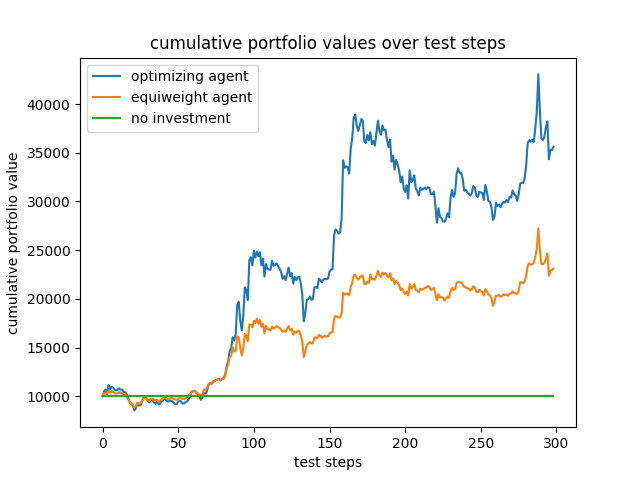

In [3]:
from IPython.display import Image
Image(filename='cpv_crypto_cnn.png')